# Performance of Bio-NICA on image sources

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nica_algorithms import bio_nica_direct, bio_nica_indirect, two_layer_nsm, nonnegative_pca
from util import permutation_error, add_fill_lines

### Load desired dataset

In [2]:
S = np.load('datasets/odor/sources.npy')
X = np.load('datasets/odor/mixtures.npy')

s_dim = S.shape[0]
x_dim = X.shape[0]
samples = S.shape[1]

### Bio-NICA

In [62]:
epochs = 10; iters = epochs*samples

In [73]:
trials = 10 # set the number of trials

bionica_direct_err = np.zeros((trials,iters))
bionica_indirect_err = np.zeros((trials,iters))
nsm_err = np.zeros((trials,iters))
npca_err = np.zeros((trials,iters))

In [74]:
sig, U = np.linalg.eig(np.cov(X))

In [75]:
# noncentered whitening for Nonnegative PCA

sig, U = np.linalg.eig(np.cov(X))

X_white = U[:,:5]@np.diag([1./np.sqrt(sig[0]),1./np.sqrt(sig[1]),1./np.sqrt(sig[2]),1./np.sqrt(sig[3]),1./np.sqrt(sig[4])])@U[:,:5].T@X

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
        
    # initialize algorithms

    n_dim = s_dim

    bionica_indirect = bio_nica_indirect(s_dim, x_dim, n_dim, eta0=1e-3, decay=0)
    bionica_direct = bio_nica_direct(s_dim, x_dim, eta0=1e-4, decay=0, tau=0.01)
    nsm = two_layer_nsm(s_dim, x_dim, eta0=1e-2, decay=0)
    npca = nonnegative_pca(s_dim, x_dim, eta0=1e-2, decay=0)

    bionica_indirect_Y = np.zeros((s_dim,iters))
    bionica_direct_Y = np.zeros((s_dim,iters))
    nsm_Y = np.zeros((s_dim,iters))
    npca_Y = np.zeros((s_dim,iters))
    
    # data matrix for keeping track of permuted sources
    
    S_perm = np.zeros((s_dim,iters))
    
    # run online algorithms
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')

        idx = np.random.permutation(samples) # random permutation

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            S_perm[:,i_iter] = S[:,idx[i_sample]]
            
            x = X[:,idx[i_sample]]
            x_white = X_white[:,idx[i_sample]]

            bionica_indirect_Y[:,i_iter] = bionica_indirect.fit_next(x)
            bionica_direct_Y[:,i_iter] = bionica_direct.fit_next(x)
            nsm_Y[:,i_iter] = nsm.fit_next(x)
            npca_Y[:,i_iter] = npca.fit_next(x_white)

            # if a neuron hasn't fired by the 100th iteration, we flip the feedforward weights:

            if i_epoch==0 and i_sample==100:
                for j in range(s_dim):
                    if bionica_indirect_Y[j,0:i_sample].sum()==0:
                        bionica_indirect.flip_weights(j)
                    if bionica_direct_Y[j,0:i_sample].sum()==0:
                        bionica_direct.flip_weights(j)
                    if nsm_Y[j,0:i_sample].sum()==0:
                        nsm.flip_weights(j)
                    if npca_Y[j,0:i_sample].sum()==0:
                        npca.flip_weights(j)
                        
        print(f'Bio-NICA (indirect) permutation error: {permutation_error(S[:,idx],bionica_indirect_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'Bio-NICA (direct) permutation error: {permutation_error(S[:,idx],bionica_direct_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'2-layer NSM permutation error: {permutation_error(S[:,idx],nsm_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'Nonnegative PCA permutation error: {permutation_error(S[:,idx],npca_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')

    print('Computing errors...')

    bionica_indirect_err[i_trial,:] = permutation_error(S_perm,bionica_indirect_Y)
    bionica_direct_err[i_trial,:] = permutation_error(S_perm,bionica_direct_Y)
    nsm_err[i_trial,:] = permutation_error(S_perm,nsm_Y)
    npca_err[i_trial,:] = permutation_error(S_perm,npca_Y)

    print(f'Final Bio-NICA (indirect) permutation error: {bionica_indirect_err[i_trial,-1]}')
    print(f'Final Bio-NICA (direct) permutation error: {bionica_direct_err[i_trial,-1]}')
    print(f'Final 2-layer NSM permutation error: {nsm_err[i_trial,-1]}')
    print(f'Final Nonnegative PCA permutation error: {npca_err[i_trial,-1]}')

Trial 1 out of 10:
Epoch 1 out of 10:
PP.T close to degenerate
Bio-NICA (indirect) permutation error: 1.081317486614947
Bio-NICA (direct) permutation error: 0.08104514580445793
2-layer NSM permutation error: 0.0698989304385768
Nonnegative PCA permutation error: 0.02707622682337816
Epoch 2 out of 10:
PP.T close to degenerate
Bio-NICA (indirect) permutation error: 0.5967420693012117
Bio-NICA (direct) permutation error: 0.05618520808851254
2-layer NSM permutation error: 0.0006738109693070864
Nonnegative PCA permutation error: 0.000591520776448375
Epoch 3 out of 10:
Bio-NICA (indirect) permutation error: 0.013098919440591782
Bio-NICA (direct) permutation error: 0.056218050567928154
2-layer NSM permutation error: 0.0005987561932675506
Nonnegative PCA permutation error: 0.0005906052125316964
Epoch 4 out of 10:
Bio-NICA (indirect) permutation error: 0.013399993503387345
Bio-NICA (direct) permutation error: 0.06012872339461409
2-layer NSM permutation error: 0.0005803235946140662
Nonnegative PC

### Comparison plots

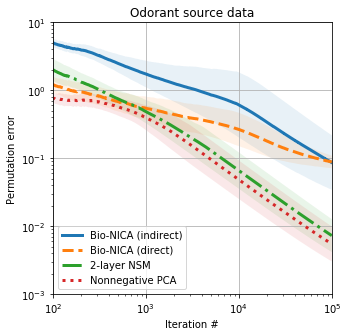

In [77]:
linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, bionica_indirect_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA (indirect)'})
add_fill_lines(ax, t, bionica_direct_err, plot_kwargs={'ls': '--', 'lw': linewidth, 'label': 'Bio-NICA (direct)'})
add_fill_lines(ax, t, nsm_err, plot_kwargs={'ls': '-.', 'lw': linewidth, 'label': '2-layer NSM'})
add_fill_lines(ax, t, npca_err, plot_kwargs={'ls': ':', 'lw': linewidth, 'label': 'Nonnegative PCA'})

ax.loglog()

plt.title(f"Odorant source data")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Iteration #')
plt.ylabel('Permutation error')
plt.xlim((1e2,iters))
# plt.ylim(bottom=10**-3,)
plt.ylim(10**-3,10**1)

# plt.savefig(f'plots/odors.png', dpi=300, transparent='true', bbox_inches='tight')
plt.show()